### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# carregar o .env com as credenciais
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")


# detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"


# parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.humanresources-employee"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"


# configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


#doc: tables_to_process: lista de tabelas que serão processadas
#     output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned

In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.humanresources-employee']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Setup inicial do df para realizar a EDA 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.raw_data.humanresources-employee
Lendo os dados do BigQuery...
Tabela humanresources_employee processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: humanresources_employee


In [7]:
# Atribuir o df a uma variável com nome mais simples
humanresources_employee = df_processados['humanresources_employee']

print(f"Colunas: {humanresources_employee.shape[1]}\nLinhas: {humanresources_employee.shape[0]}")

Colunas: 15
Linhas: 3770


In [8]:
# Identificar duplicadas
duplicadas = humanresources_employee[humanresources_employee.duplicated(subset=['businessentityid'], keep=False)]

# Verificar se existem duplicadas
if not duplicadas.empty:
    
    duplicadas_ordenadas = duplicadas.sort_values(by=['businessentityid', 'modifieddate'])

    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
      businessentityid  nationalidnumber                  loginid                 jobtitle   birthdate maritalstatus gender    hiredate  salariedflag  vacationhours  sickleavehours  currentflag                               rowguid              modifieddate organizationnode
3396                 1         295847284     adventure-works\ken0  Chief Executive Officer  1969-01-29             S      M  2009-01-14          True             99              69         True  f01251e5-96a3-448d-981e-0f99d789110d 2014-06-30 00:00:00+00:00                /
3397                 1         295847284     adventure-works\ken0  Chief Executive Officer  1969-01-29             S      M  2009-01-14          True             99              69         True  f01251e5-96a3-448d-981e-0f99d789110d 2014-06-30 00:00:00+00:00                /
3398                 1         295847284     adventure-works\ken0  Chief Executive Officer  1969-01-29             S      M  2009-01-14          True    

In [9]:
# Remover duplicadas* 
humanresources_employee = humanresources_employee.drop_duplicates(subset=['businessentityid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(humanresources_employee)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = humanresources_employee.copy()


#doc: bkp = backup (cópia)
#doc*: mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
#      Importante, pois se houver erro na ingestão (duplicação), mantém os dados íntegros.

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 290


In [10]:
# Ordenar e exibir o df por 'businessentityid'
humanresources_employee = humanresources_employee.sort_values(by=['businessentityid'])

print(humanresources_employee)

      businessentityid  nationalidnumber                   loginid                       jobtitle   birthdate maritalstatus gender    hiredate  salariedflag  vacationhours  sickleavehours  currentflag                               rowguid              modifieddate organizationnode
3768                 1         295847284      adventure-works\ken0        Chief Executive Officer  1969-01-29             S      M  2009-01-14          True             99              69         True  f01251e5-96a3-448d-981e-0f99d789110d 2014-06-30 00:00:00+00:00                /
3628                 2         245797967    adventure-works\terri0  Vice President of Engineering  1971-08-01             S      F  2008-01-31          True              1              20         True  45e8f437-670d-4409-93cb-f9424a40d6ee 2014-06-30 00:00:00+00:00              /1/
3483                 3         509647174  adventure-works\roberto0            Engineering Manager  1974-11-12             M      M  2007-11-11          Tr

In [11]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in humanresources_employee.columns:   
    missing_rows = humanresources_employee[humanresources_employee[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'businessentityid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'businessentityid'.

Coluna 'nationalidnumber': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'nationalidnumber'.

Coluna 'loginid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'loginid'.

Coluna 'jobtitle': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'jobtitle'.

Coluna 'birthdate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'birthdate'.

Coluna 'maritalstatus': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'maritalstatus'.

Coluna 'gender': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'gender'.

Coluna 'hiredate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'hiredate'.

Coluna 'salariedflag': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salariedflag'.

Coluna 'vacationhours': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'vacationhours'.

Coluna 'sickleavehours': 0 linhas ausentes.
Nenhuma li

In [12]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.
valores_unicos = humanresources_employee.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

#doc: currentflag possue somente 1 valor, o que indica que pode ser somente valores True ou False.

Valores únicos incluindo NaN:
businessentityid    290
nationalidnumber    290
loginid             290
jobtitle             67
birthdate           275
maritalstatus         2
gender                2
hiredate            164
salariedflag          2
vacationhours       100
sickleavehours       51
currentflag           1
rowguid             290
modifieddate          2
organizationnode    290
dtype: int64


In [13]:
# Listar colunas binárias esperadas e verificar valores únicos e suas distribuições
coluna_binaria = ['currentflag', 'salariedflag']

for col in coluna_binaria:
    unique_values = humanresources_employee[col].unique()
    print(f"Valores únicos em '{col}': {unique_values}")
    print(f"Distribuição de '{col}':")
    print(humanresources_employee[col].value_counts())
    print()


#doc: garantir que colunas binárias contenham apenas valores esperados, no caso True ou False e identificar anomalias verificando os valores únicos em cada coluna; valores fora do padrão binário, facilitando a validação e correção
#doc: currentflag só tem True, isso indica que a coluna é constante e não agrega informações úteis para a análise, pois não há variabilidade nos dados, ao contrario de salariedflag, que é uma coluna válida para análise, já que possui variabilidade e pode ser utilizada para segmentar os dados

Valores únicos em 'currentflag': <BooleanArray>
[True]
Length: 1, dtype: boolean
Distribuição de 'currentflag':
currentflag
True    290
Name: count, dtype: Int64

Valores únicos em 'salariedflag': <BooleanArray>
[True, False]
Length: 2, dtype: boolean
Distribuição de 'salariedflag':
salariedflag
False    238
True      52
Name: count, dtype: Int64



In [14]:
# Verificar se há funcionários ativos com `false`*
print("Funcionários ativos errados:", humanresources_employee[humanresources_employee['currentflag'] != True])

# Validar datas
# Converter 'hiredate' e 'modifieddate' para datetime sem timezone
hiredate = pd.to_datetime(humanresources_employee['hiredate'], errors='coerce').dt.tz_localize(None)
modifieddate = pd.to_datetime(humanresources_employee['modifieddate'], errors='coerce').dt.tz_localize(None)

# Contratações futuras**
print("Contratações futuras:", humanresources_employee[hiredate > pd.Timestamp.now()])

# Modifieddate antes de hiredate***
print("Modifieddate antes de hiredate:", humanresources_employee[modifieddate < hiredate])


#doc*: funcionários desligados / demitidos (False) não devem ser tratados como ativos no sistema, evitando inconsistências
#doc**: datas futuras indicam erros nos registros, pois contratações devem ocorrer em datas passadas
#doc***: um registro não pode ser modificado antes da contratação, pois seria um erro lógico nos dados

Funcionários ativos errados: Empty DataFrame
Columns: [businessentityid, nationalidnumber, loginid, jobtitle, birthdate, maritalstatus, gender, hiredate, salariedflag, vacationhours, sickleavehours, currentflag, rowguid, modifieddate, organizationnode]
Index: []
Contratações futuras: Empty DataFrame
Columns: [businessentityid, nationalidnumber, loginid, jobtitle, birthdate, maritalstatus, gender, hiredate, salariedflag, vacationhours, sickleavehours, currentflag, rowguid, modifieddate, organizationnode]
Index: []
Modifieddate antes de hiredate: Empty DataFrame
Columns: [businessentityid, nationalidnumber, loginid, jobtitle, birthdate, maritalstatus, gender, hiredate, salariedflag, vacationhours, sickleavehours, currentflag, rowguid, modifieddate, organizationnode]
Index: []


In [15]:
#verificar informações do df
humanresources_employee.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, 3768 to 3668
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   businessentityid  290 non-null    Int64              
 1   nationalidnumber  290 non-null    Int64              
 2   loginid           290 non-null    object             
 3   jobtitle          290 non-null    object             
 4   birthdate         290 non-null    dbdate             
 5   maritalstatus     290 non-null    object             
 6   gender            290 non-null    object             
 7   hiredate          290 non-null    dbdate             
 8   salariedflag      290 non-null    boolean            
 9   vacationhours     290 non-null    Int64              
 10  sickleavehours    290 non-null    Int64              
 11  currentflag       290 non-null    boolean            
 12  rowguid           290 non-null    object             
 13  modifi

In [16]:
#avaliando as variáveis qualitativas*

coluna_quantitativa = ["jobtitle", "maritalstatus", "gender"]
for col in coluna_quantitativa:
    counts = humanresources_employee[col].value_counts().nlargest(10)
    percentages = (counts / humanresources_employee.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(summary)    


#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, jobtitle, maritalstatus, gender, por exemplo

                              qtde.      %
jobtitle                                  
Production Technician - WC60     26  8.97%
Production Technician - WC40     26  8.97%
Production Technician - WC50     26  8.97%
Production Technician - WC30     25  8.62%
Production Technician - WC20     22  7.59%
Production Technician - WC10     17  5.86%
Production Technician - WC45     15  5.17%
Sales Representative             14  4.83%
Buyer                             9  3.10%
Marketing Specialist              5  1.72%
               qtde.       %
maritalstatus               
M                146  50.34%
S                144  49.66%
        qtde.       %
gender               
M         206  71.03%
F          84  28.97%


In [17]:
# Variáveis quantitativas*

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['sickleavehours', 'vacationhours']

# Estatísticas Descritivas das colunas numéricas*
print(humanresources_employee[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = humanresources_employee[col].quantile(0.25)
    q3 = humanresources_employee[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = humanresources_employee[(humanresources_employee[col] < lower_bound) | (humanresources_employee[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados
#doc****: as colunas analisadas não apresentam outliers, pois os dados estão dentro dos limites esperados, sugerindo que não há necessidade de tratamento adicional para valores extremos. Isso indica boa qualidade dos dados para essas variáveis e que elas estão prontas para serem exportadas ou utilizadas em análises e modelos

       sickleavehours  vacationhours
count          290.00         290.00
mean            45.31          50.61
std             14.54          28.79
min             20.00           0.00
25%             33.00          26.25
50%             46.00          51.00
75%             58.00          75.00
max             80.00          99.00

Coluna: sickleavehours
Limite inferior: -4.5, Limite superior: 95.5
Outliers detectados (0):
Empty DataFrame
Columns: [sickleavehours]
Index: []

Coluna: vacationhours
Limite inferior: -46.875, Limite superior: 148.125
Outliers detectados (0):
Empty DataFrame
Columns: [vacationhours]
Index: []


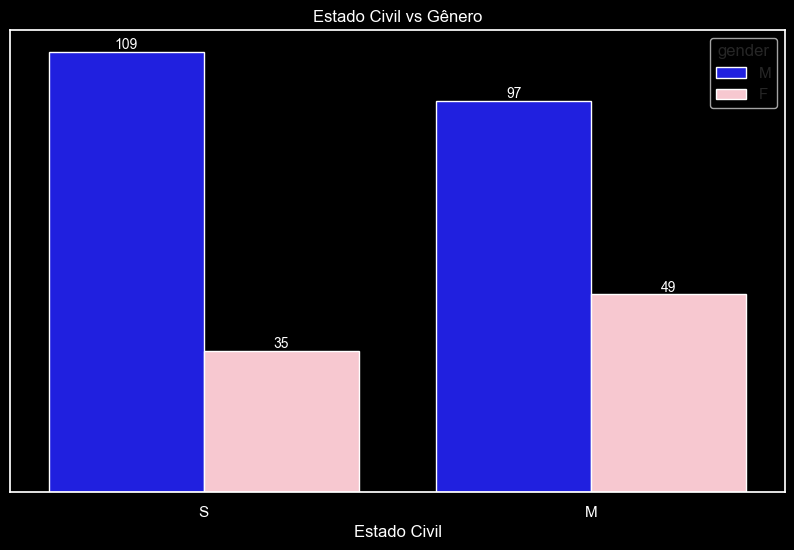

In [18]:
# Configurar o gráfico
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# Gráfico maritalstatus x gender
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x='maritalstatus', hue='gender', data=humanresources_employee,
    palette={"M": "blue", "F": "pink"}  
)
plt.title('Estado Civil vs Gênero', color='white')
plt.ylabel("")
plt.xlabel("Estado Civil", color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_yticks([])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', color='white', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
plt.show()


#doc: maritalstatus: M = married | casado ; S = single | Solteiro
#     gender: M = male | homem ; F = female | mulher 

c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


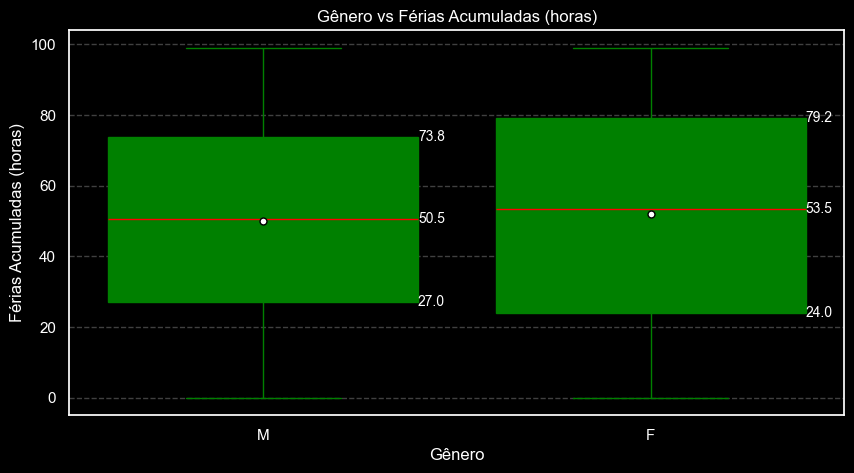

In [19]:
# Calcular os quartis
quartiles = humanresources_employee.groupby('gender')['vacationhours'].quantile([0.25, 0.50, 0.75]).unstack()

# Gráfico gender x vacationhours
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    x='gender', y='vacationhours', data=humanresources_employee, showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 5},
    boxprops={"color": "green"}, whiskerprops={"color": "green"}, capprops={"color": "green"},
    medianprops={"color": "red"}, flierprops={"markerfacecolor": "blue", "markersize": 5}
)
plt.title('Gênero vs Férias Acumuladas (horas)', color='white')
plt.ylabel("Férias Acumuladas (horas)", color='white')
plt.xlabel("Gênero", color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

for gender, values in quartiles.iterrows():
    x_pos = list(humanresources_employee['gender'].unique()).index(gender)  
    offset = 0.4

    for i, quartile in enumerate(values):
        y_pos = quartile
        ax.text(x=x_pos + offset, y=y_pos, s=f"{quartile:.1f}", ha='left', va='center', fontsize=10, color='white')

plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
plt.show()


#doc: vacationhours: férias acumuladas por funcionário

c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


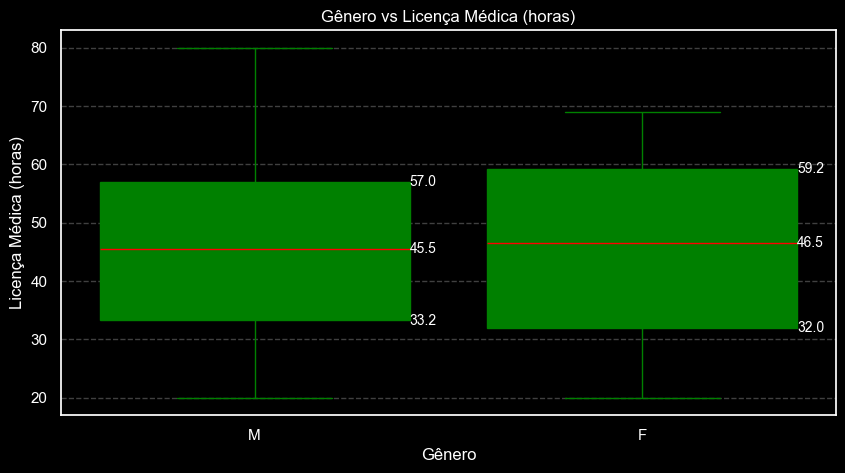

In [20]:
# Calcular os quartis
quartiles = humanresources_employee.groupby('gender')['sickleavehours'].quantile([0.25, 0.50, 0.75]).unstack()

# Gráfico gender x sickleavehours
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    x='gender', y='sickleavehours', data=humanresources_employee,
    boxprops={"color": "green"}, whiskerprops={"color": "green"}, capprops={"color": "green"},
    medianprops={"color": "red"}, flierprops={"markerfacecolor": "blue", "markersize": 5}
)
plt.title('Gênero vs Licença Médica (horas)', color='white')
plt.ylabel("Licença Médica (horas)", color='white')
plt.xlabel("Gênero", color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

for gender, values in quartiles.iterrows():
    x_pos = list(humanresources_employee['gender'].unique()).index(gender) 
    offset = 0.4

    for i, quartile in enumerate(values):
        y_pos = quartile
        ax.text(x=x_pos + offset, y=y_pos, s=f"{quartile:.1f}", ha='left', va='center', fontsize=10, color='white')

plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
plt.show()


#doc: sickleavehours: horas de licença médica por funcionário

In [21]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['humanresources_employee'] = humanresources_employee

In [22]:
# Padronizar colunas com valores textuais*

humanresources_employee['jobtitle'] = humanresources_employee['jobtitle'].str.strip().str.upper()
humanresources_employee['gender'] = humanresources_employee['gender'].str.strip().str.upper()
humanresources_employee['maritalstatus'] = humanresources_employee['maritalstatus'].str.strip().str.upper()
humanresources_employee['loginid'] = humanresources_employee['loginid'].str.strip().str.upper()
humanresources_employee['rowguid'] = humanresources_employee['rowguid'].str.strip().str.upper()

print(humanresources_employee.head())

#doc*: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

      businessentityid  nationalidnumber                   loginid                       jobtitle   birthdate maritalstatus gender    hiredate  salariedflag  vacationhours  sickleavehours  currentflag                               rowguid              modifieddate organizationnode
3768                 1         295847284      ADVENTURE-WORKS\KEN0        CHIEF EXECUTIVE OFFICER  1969-01-29             S      M  2009-01-14          True             99              69         True  F01251E5-96A3-448D-981E-0F99D789110D 2014-06-30 00:00:00+00:00                /
3628                 2         245797967    ADVENTURE-WORKS\TERRI0  VICE PRESIDENT OF ENGINEERING  1971-08-01             S      F  2008-01-31          True              1              20         True  45E8F437-670D-4409-93CB-F9424A40D6EE 2014-06-30 00:00:00+00:00              /1/
3483                 3         509647174  ADVENTURE-WORKS\ROBERTO0            ENGINEERING MANAGER  1974-11-12             M      M  2007-11-11          Tr

In [23]:
# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
 
    output_table = f"{output_dataset}.{table_name}"
   
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela humanresources_employee exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.humanresources_employee.
